# Toxic Comment Classification

## Importing required packages

In [26]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from collections import Counter

from sklearn.pipeline import Pipeline
from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Data Preprocessing and Exploratory Data Analyasis

In [27]:
# mounting googledrive to access datasets
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Data

In [28]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")
test_y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test_labels.csv")

### Data Analysis

In [29]:
train.head(7)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


In [30]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [32]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


Given graph gives visualization between comment length and frequency of the comments with that particular length.

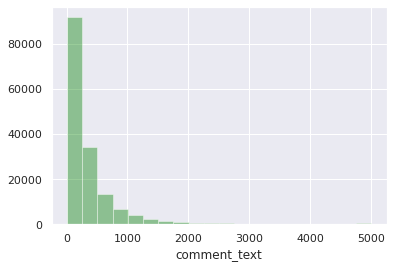

In [77]:
sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="green")

In [34]:
# Accesing labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum() 

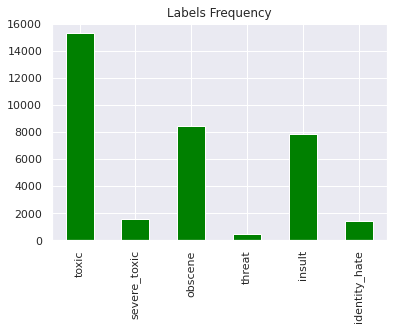

In [76]:
# below plot gives the frequency of the lables
label_count.plot(kind='bar', title='Labels Frequency', color='green')

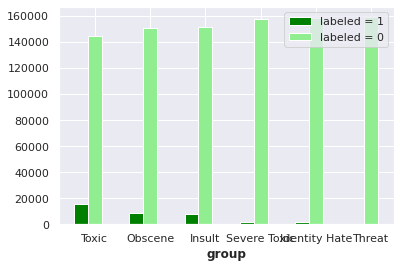

In [75]:
# Code to draw bar graph for visualising distribution of classes within each label.
barWidth = 0.25

bars1 = [sum(train['toxic'] == 1), sum(train['obscene'] == 1), sum(train['insult'] == 1), sum(train['severe_toxic'] == 1),
         sum(train['identity_hate'] == 1), sum(train['threat'] == 1)] # labeled 1
bars2 = [sum(train['toxic'] == 0), sum(train['obscene'] == 0), sum(train['insult'] == 0), sum(train['severe_toxic'] == 0),
         sum(train['identity_hate'] == 0), sum(train['threat'] == 0)] # labeled 0

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# plotting 2 bargraph with different colours
plt.bar(r1, bars1, color='green', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightgreen', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate',
                                                       'Threat'])
plt.legend()
plt.show()

To get a better understanding of what the comments look like, below are examples of one clean (non-toxic) comment and one toxic (specifically, with label "toxic") comment.

In [37]:
# example of clean comment
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [38]:
# example of toxic comment
train[train.toxic == 1].iloc[1, 1]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

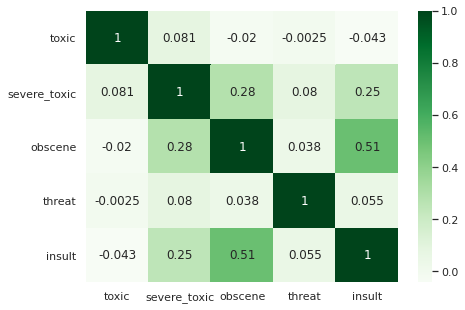

In [74]:
# Cross correlation matrix across labels
rowsums = train.iloc[:, 2:].sum(axis=1)
temp = train.iloc[:, 2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Greens")

From the above Heat map we can observe that most of the obscene comments are insult.

## Tokenizing and lemmatization

In [40]:
test_labels = ["toxic", "severe_toxic", "obscene",
               "threat", "insult", "identity_hate"]

In [41]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text. 
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower() # convert to lower case
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # removing punctuations
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer() # lemmatization
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

#### TFidf Vectorizer

We determined to use TFIDF to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

For example: Since this corpus consists of data from the Wikipedia's talk page edits, the words such as wiki, Wikipedia, edit, page are very common. But for our classification purposes they do not provide us useful information.

In [42]:
from nltk.corpus import stopwords
import nltk

nltk.download('wordnet')
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Modeling and Evaluation

<a id='cv'></a>
### Cross Validation

In [46]:
# Creating classifiers with default parameters initially.
clf1 = MultinomialNB()
clf2 = LogisticRegression()
clf3 = LinearSVC()

In [47]:
def cross_validation_score(classifier, X_train, y_train):
    methods = []
    name = classifier.__class__.__name__.split('.')[-1] # getting the name of the model

    for label in test_labels: # iterating through each label
        recall = cross_val_score(
            classifier, X_train, y_train[label], cv=10, scoring='recall') # calculating recall
        f1 = cross_val_score(classifier, X_train,
                             y_train[label], cv=10, scoring='f1') # calcualting f1 score
        methods.append([name, label, recall.mean(), f1.mean()])

    return methods # retuning model name, label, recall and f1 score

In [48]:
# Calculating the cross validation F1 and Recall score for our 3 baseline models.
methods1_cv = pd.DataFrame(cross_validation_score(clf1, X_train, train))
methods2_cv = pd.DataFrame(cross_validation_score(clf2, X_train, train))
methods3_cv = pd.DataFrame(cross_validation_score(clf3, X_train, train))

In [49]:
# Creating a dataframe to show summary of results.
methods_cv = pd.concat([methods1_cv, methods2_cv, methods3_cv])
methods_cv.columns = ['Model', 'Label', 'Recall', 'F1']
meth_cv = methods_cv.reset_index()
meth_cv[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,toxic,0.482999,0.636562
1,MultinomialNB,severe_toxic,0.021938,0.042244
2,MultinomialNB,obscene,0.469167,0.622148
3,MultinomialNB,threat,0.000000,0.000000
4,MultinomialNB,insult,0.367020,0.511394
5,MultinomialNB,identity_hate,0.007832,0.015346
6,LogisticRegression,toxic,0.610696,0.731487
7,LogisticRegression,severe_toxic,0.256431,0.351530
8,LogisticRegression,obscene,0.637002,0.747363
9,LogisticRegression,threat,0.123316,0.206632


The linear SVC model and Logistic Regression model perform better. Multinomial Naive Bayes does not perform well, especially for the threat label and identity_hate.



### Modeling and Evaluation

Now we shall see how these three models perform on the actual prediction i.e, the test dataset.

In [50]:
def score(classifier, X_train, y_train, X_test, y_test):
    """
    Calculate Hamming-loss, F1, Recall for each label on test dataset.
    """
    methods = []
    hloss = []
    name = classifier.__class__.__name__.split('.')[-1]
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels: # iterating through each label
        classifier.fit(X_train, y_train[label]) # fitting the train data
        predicted = classifier.predict(X_test) # predicting the test data set

        predict_df[label] = predicted

        recall = recall_score(y_test[y_test[label] != -1][label],
                              predicted[y_test[label] != -1],
                              average="weighted") # calculating score
        f1 = f1_score(y_test[y_test[label] != -1][label],
                      predicted[y_test[label] != -1],
                      average="weighted") # calculating f1 score

        conf_mat = confusion_matrix(y_test[y_test[label] != -1][label],
                                    predicted[y_test[label] != -1]) # calculating confusion matrix

        methods.append([name, label, recall, f1, conf_mat])

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7]) # calculating hamming loss
    hloss.append([name, hamming_loss_score])

    return hloss, methods

In [51]:
# Calculating the Hamming-loss F1 and Recall score for our 3 baseline models.
h1, methods1 = score(clf1, X_train, train, X_test, test_y)
h2, methods2 = score(clf2, X_train, train, X_test, test_y)
h3, methods3 = score(clf3, X_train, train, X_test, test_y)

In [52]:
# Creating a dataframe to show summary of results.
methods1 = pd.DataFrame(methods1)
methods2 = pd.DataFrame(methods2)
methods3 = pd.DataFrame(methods3)
methods = pd.concat([methods1, methods2, methods3])
methods.columns = ['Model', 'Label', 'Recall', 'F1', 'Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,toxic,0.935196,0.930919
1,MultinomialNB,severe_toxic,0.994436,0.992145
2,MultinomialNB,obscene,0.962987,0.957902
3,MultinomialNB,threat,0.996702,0.995056
4,MultinomialNB,insult,0.960158,0.953453
5,MultinomialNB,identity_hate,0.988887,0.983408
6,LogisticRegression,toxic,0.935728,0.937031
7,LogisticRegression,severe_toxic,0.993123,0.992762
8,LogisticRegression,obscene,0.965957,0.964267
9,LogisticRegression,threat,0.996530,0.995725


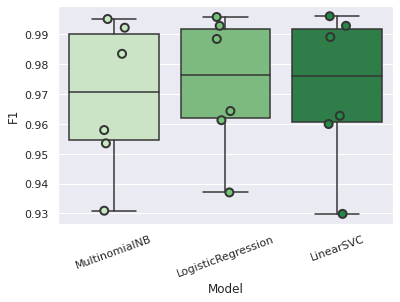

In [73]:
# Visualizing F1 score results through box-plot.
ax = sns.boxplot(x='Model', y='F1', data=methods, palette="Greens")
sns.stripplot(x='Model', y='F1', data=methods,
              size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Greens")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.show()

Above are the result table and plot showing a comparison between these different models after training them and see how these models perform on the test data.

Notice that Muninomial Naive Bayes does not perform as well as the other two models while Linear SVC in general out performs the others based on F1 score.

###  Confusion Matrix visualization

In [71]:
def drawConfusionMatrix(cm):
    """
    Plot Confusion matrix of input cm.
    """
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm,
                annot=True,
                annot_kws={"size": 16},
                cmap="Greens",
                fmt='.2f',
                linewidths=2,
                linecolor='steelblue',
                xticklabels=("No", "Yes"),
                yticklabels=("No", "Yes"))

    plt.ylabel('True', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.show()

In [56]:
def Matrix(label):
    """
    Plot Confusion matrix for each label and call function drawConfusionMatrix().
    """
    print(f"-------------- {label} labelling --------------")
    labels = {"toxic": 0, "severe_toxic": 1, "obscene": 2,
              "threat": 3, "insult": 4, "identity_hate": 5}

    pos = labels[label]
    for i in range(pos, len(meth), 6):
        print()
        print(f"--------------  {meth['Model'][i]}  --------------")
        cm = meth['Confusion_Matrix'][i]
        drawConfusionMatrix(cm)

Below shows the confusion matrix for label toxic. Notice that all models predict Non-toxic labels pretty well because most of our data are non-toxic. However, Multinomial NB tends to predict more toxic comments to non-toxic while Linear SVC is doing a great job in classifying toxic comments.

Choose a class for the Confusion Matrix: toxic
-------------- toxic labelling --------------

--------------  MultinomialNB  --------------


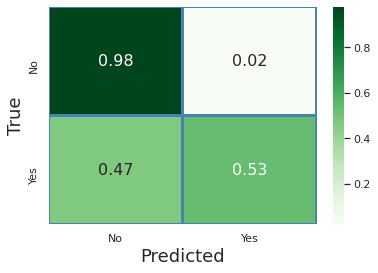


--------------  LogisticRegression  --------------


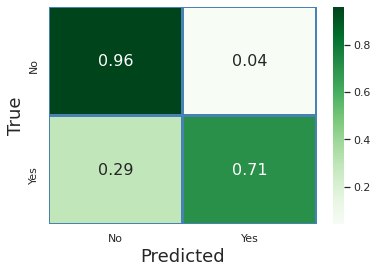


--------------  LinearSVC  --------------


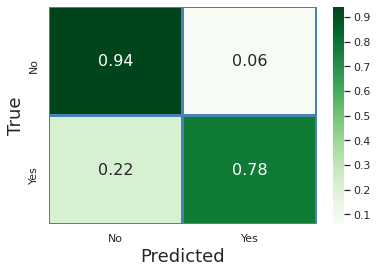

In [72]:
token = input('Choose a class for the Confusion Matrix: ')
Matrix(token.lower())

Based on the above comparison, we could say for default settings, LinearSVC performs better than anyone for 'toxic' label.




### Aggregated Hamming Loss Score


In [58]:
# Creating a dataframe to summarize Hamming-loss
hl1_df = pd.DataFrame(h1)
hl2_df = pd.DataFrame(h2)
hl3_df = pd.DataFrame(h3)

In [59]:
hammingloss = pd.concat([hl1_df, hl2_df, hl3_df])
hammingloss.columns = ['Model', 'Hamming_Loss']
hl = hammingloss.reset_index()
hl[['Model', 'Hamming_Loss']]

,Model,Hamming_Loss
0,MultinomialNB,0.026939
1,LogisticRegression,0.025670
2,LinearSVC,0.028476


Across all models , **Logistic Regression** is doing a great job overall since it has the lowest percentage of incorrect labels.

### Pipelines
Let's clean the code with pipeline and use some manually chosen hyperparameters to check how each model behaves. Since the greatest concern now is the imbalanced data, we decide to manually adjust class_weight for the models to see if we can achieve better results.

Since Logistic Regression and Linear SVM are performing better, we will focus on these two models.

In [60]:
pipe_lr = Pipeline([
    ('lr', LogisticRegression(class_weight="balanced"))
])

pipe_linear_svm = Pipeline([
    ('svm', LinearSVC(class_weight={1: 20}))
])

pipelines = [pipe_lr, pipe_linear_svm]

In [61]:
score_df = []
for pipe in pipelines: # iterating through different models
    f1_values = []
    recall_values = []
    hl = []
    training_time = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']
    for label in test_labels:
        start = timer() 
        pipe.fit(X_train, train[label]) # fitting the train data
        train_time = timer() - start # calculating training time
        predicted = pipe.predict(X_test)
        predict_df[label] = predicted

        f1_values.append(f1_score(
            test_y[test_y[label] != -1][label], predicted[test_y[label] != -1], average="weighted")) # calculating f1 score
        recall_values.append(recall_score(
            test_y[test_y[label] != -1][label], predicted[test_y[label] != -1], average="weighted")) # calculating recall
        training_time.append(train_time)
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1] # getting came of the model

    hamming_loss_score = hamming_loss(
        test_y[test_y['toxic'] != -1].iloc[:, 1:7], predict_df[test_y['toxic'] != -1].iloc[:, 1:7]) # calculating hamming loss

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, mean(training_time)]
    score_df.append(val)

In [62]:
# creating data frames for scores of the models
scores = pd.DataFrame(score_df,)
scores.columns = ['Model', 'F1', 'Recall', 'Hamming_Loss', 'Training_Time']
scores

,Model,F1,Recall,Hamming_Loss,Training_Time
0,LogisticRegression,0.947934,0.934074,0.065926,5.832178
1,LinearSVC,0.951508,0.941634,0.058366,8.005707


After adjusting class_weight, we are getting better results than the basic models. So we try to improve by tuning hyperparameter.

## Hyperparameter Tuning with Grid Search 

Now we use grid search to seek for the "optimal" hyperparameters for the basic models that we've chose. Since for each label it takes lot of time to calculate the parameters we use the most common lable 'toxic' to tune hyperparameters.

### Logistic Regression Tuning

In [63]:
logistic_regression_classifier = LogisticRegression()

parameter_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                  'class_weight': [None, 'balanced']} # giving different values for different parameters

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(logistic_regression_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1') # grid_search

grid_search.fit(X_train, train['toxic']) # fitting the train data

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_ # Getting best parameters

Best parameters: {'class_weight': None, 'solver': 'liblinear'}


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### SVM Classifier Tuning

In [64]:
svm_classifier = LinearSVC()

parameter_grid = {'class_weight': [None, 'balanced'],
                  'C': [1, 5, 10]}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(svm_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train, train['toxic'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best parameters: {'C': 1, 'class_weight': None}


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

###  Model Selection

We will then compare these two models based on their tunned hyperparameters, we will also include training time as one of the metric when we compare models.

In [65]:
svm_clf = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

lr_clf = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

tunned_model_score_df = []
# evaluating both models by calculating training time, hamming loss, f1 score and recall
for model in [svm_clf, lr_clf]:
    f1_values = []
    recall_values = []
    hl = []
    training_time = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        start = timer()
        model.fit(X_train, train[label])
        training_time.append(timer() - start)
        predicted = model.predict(X_test)
        predict_df[label] = predicted

        f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                                  predicted[test_y[label] != -1],
                                  average="weighted"))
        recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                          predicted[test_y[label] != -1],
                                          average="weighted"))
        name = model.__class__.__name__

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, sum(training_time)]

    tunned_model_score_df.append(val)

In [66]:
tunned_scores = pd.DataFrame(tunned_model_score_df,)
tunned_scores.columns = ['Model', 'F1',
                         'Recall', 'Hamming_Loss', 'Traing_Time']
tunned_scores

,Model,F1,Recall,Hamming_Loss,Traing_Time
0,LinearSVC,0.971706,0.971524,0.028476,5.040865
1,LogisticRegression,0.973220,0.974325,0.025675,8.879947
